In [52]:
%matplotlib inline
import numpy as np
import pyworld as pw
import soundfile as sf
from IPython.display import Audio
from nnmnkwii.preprocessing.f0 import interp1d
import librosa
import librosa.display
import matplotlib.pyplot as plt

## Instalación de librerías necesarias

In [3]:
# Requisitos
!pip install pyworld
!pip install nnmnkwii
!pip install soundfile
!pip install librosa

  Using cached nnmnkwii-0.1.1.tar.gz (2.0 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [594 lines of output]
        Using cached wheel-0.38.4-py3-none-any.whl (36 kB)
        Using cached setuptools-67.0.0-py3-none-any.whl (1.1 MB)
        Using cached Cython-0.29.33-py2.py3-none-any.whl (987 kB)
        Using cached numpy-1.19.5.zip (7.3 MB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached scipy-1.10.0-cp39-cp39-macosx_12_0_arm64.whl (28.9 MB)
        error: subprocess-exited-with-error
      
        × Building wh

## Definición de funciones para trabajar con el vocoder WORLD

In [237]:
def world(x, fs=16000, frame_period=5):
    '''
    Función para codificar una señal de audio x muestreada a fs Hz con el vocoder World (https://github.com/mmorise/World)
    
    Parameters:
    x: señal de voz.
    fs: frecuencia de muestreo.
    frame_period: indica cada cuánto se calculan las tramas (en ms). Valores recomendados: 5 ó 10 ms.
    
    Returns:
    f0: Vector con los valores de F0 de la señal (Tam: num_frames).
    sp: Matrix 2d con el espectro suavizado de la señal (Tam: num_frames * 513).
    ap: Matriz de aperiodicidades (Tam: num_frames * 513).
    '''
    F0_FLOOR = 80
    F0_CEIL = 650
    
    waveform = x.astype(dtype=np.double)
    _f0, t = pw.harvest(waveform, fs, f0_floor=F0_FLOOR, f0_ceil=F0_CEIL, frame_period=frame_period)    # raw pitch extractor
    f0 = pw.stonemask(waveform, _f0, t, fs)  # pitch refinement
    sp = pw.cheaptrick(waveform, f0, t, fs, f0_floor=F0_FLOOR)  # extract smoothed spectrogram
    # To circunvent the error when working with 8 kHz files (see https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder/issues/54)
    ap = pw.d4c(waveform, f0, t, fs)         # extract aperiodicity    
    if fs == 8000:
        # waveform = librosa.resample(waveform, orig_sr=fs, target_sr=16000)
        # ap = pw.d4c(waveform, f0, t, 16000)         # extract aperiodicity
        ap *= 0
    return f0, sp, ap

In [221]:
def code_world_params(f0, sp, ap, fs=16000, num_mfcc=25):
    '''
    Comprime los parámetros extraídos por World.
    
    Parameters:
    f0: vector con los valores de F0, incluidos las etiquetas Sonoro/Sordo.
    sp: Matrix 2d con el espectro suavizado de la señal.
    ap: Matriz de aperiodicidades.
    fs: frecuencia de muestreo.
    num_mfcc: Número de MFCC que se calculan por trama a partir de la matriz sp.
    
    
    Returns:
    lf0: Vector con los valores de F0 interpolados en escala logarítmica.
    vuv: Vector con las decisiones sonoro/sordo.
    mfcc: Matriz de MFCCs
    bap: Matriz con las band-aperiodicities.
    '''
    mfcc = pw.code_spectral_envelope(sp, fs, num_mfcc)
    # Workaround when working with 8000kHz audio (see https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder/issues/54)
    if fs == 8000:
        bap = ap
    else:
        bap = pw.code_aperiodicity(ap, fs)
    vuv = (f0 > 0)
    # Interpolate the F0 for the unvoiced segments and apply a log-compression
    lf0 = np.log(interp1d(f0, kind='slinear'))
    return lf0, vuv, mfcc, bap

In [222]:
def decode_world_params(lf0, vuv, mfcc, bap, fs=16000):
    '''
    Decodifica (descomprime) los parámetros comprimidos por la función code_world_params para
    ser usados para sintetizar voz.
    
    Parameters:
    lf0: Vector con los valores de F0 interpolados en escala logarítmica.
    vuv: Vector con las decisiones sonoro/sordo.
    mfcc: Matriz de MFCCs
    bap: Matriz con las band-aperiodicities.
    fs: frecuencia de muestreo.
    
    Returns:
    f0: vector con los valores de F0, incluidos las etiquetas Sonoro/Sordo.
    sp: Matrix 2d con el espectro suavizado de la señal.
    ap: Matriz de aperiodicidades.
    '''
    fft_size = pw.get_cheaptrick_fft_size(fs)
    sp = pw.decode_spectral_envelope(mfcc.copy(order='C'), fs=fs, fft_size=fft_size)
    # Workaround when working with 8000kHz audio (see https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder/issues/54)
    if fs == 8000:
        ap = bap        
    else:
        ap = pw.decode_aperiodicity(bap.copy(order='C'), fs, fft_size=fft_size)
    f0 = np.exp(lf0) * vuv    
    return f0, sp, ap

In [223]:
def synthesise(f0, sp, ap, fs=16000, frame_period=5):
    '''
    Resintetiza una señal de voz a partir de los parámetros extraídos por World.
    
    Parameters:
    f0: vector con los valores de F0, incluidos las etiquetas Sonoro/Sordo.
    sp: Matrix 2d con el espectro suavizado de la señal.
    ap: Matriz de aperiodicidades.
    fs: frecuencia de muestreo.
    frame_period: indica cada cuánto se calculan las tramas (en ms). Valores recomendados: 5 ó 10 ms.
    
    Returns:
    x: señal en el tiempo.
    '''
    x = pw.synthesize(f0.flatten(), sp, ap, fs, frame_period)
    return x

In [241]:
def world_resynthesis(x, fs, num_mfcc, whispered=False, frame_period=5):
    '''
    Resintetiza una señal de voz usando el vocoder World.
    
    Parameters:
    x: señal de voz.
    fs: frecuencia de muestreo.
    num_mfcc: número de MFCCs (p.ej. 25)
    whispered: sintentizar la señal como 'whispered voice' [default: False)
    frame_period: indica cada cuánto se calculan las tramas (en ms). Valores recomendados: 5 ó 10 ms. [Defaul= 5 ms]
   
    Returns:
    y: señal resintetizada en el tiempo.
    '''
    # Codificamos la señal con World
    f0, sp, ap = world(x, fs, frame_period)
    
    # Mostramos algunos de los parámetros extraídos por World
    plt.figure()
    plt.plot(f0), plt.title('F0'), plt.xlabel('Frame'), plt.ylabel('Hz')
    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(sp.T), ref=np.max)), plt.title('Spectrogram'), plt.xlabel('Frame')
    
    # Codificamos los parámetros extraidos por World -> **** PARA CONVERSIÓN EEG->VOZ TENEMOS QUE USAR los parámetros 'mfcc' ****
    lf0, vuv, mfcc, bap = code_world_params(f0, sp, ap, fs, num_mfcc)
    
    # Suponemos que todos los segmentos son sordos
    if whispered:
        vuv = np.zeros_like(vuv)
        bap = np.zeros_like(bap)

    # Decodificamos los parámetros y probamos a resintetizar la señal de nuevo
    f02, sp2, ap2 = decode_world_params(lf0, vuv, mfcc, bap, fs)
    y = synthesise(f02, sp2, ap2, fs, frame_period)
    
    return y

## Ejemplo de codificación y decodificación de una señal de voz a 16 kHz

In [239]:
# Leemos la señal
x, fs = sf.read('audio16kHz.wav')
Audio(x, rate=fs)

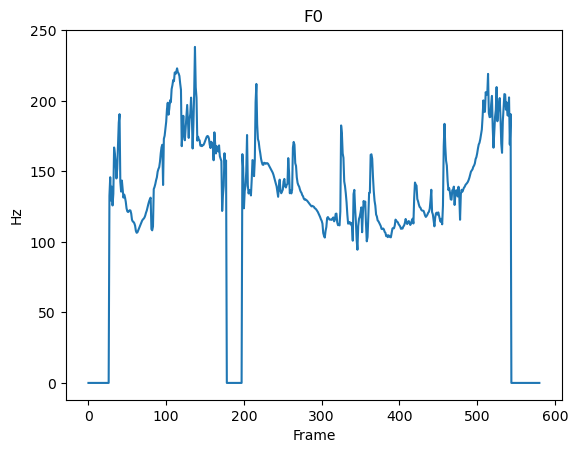

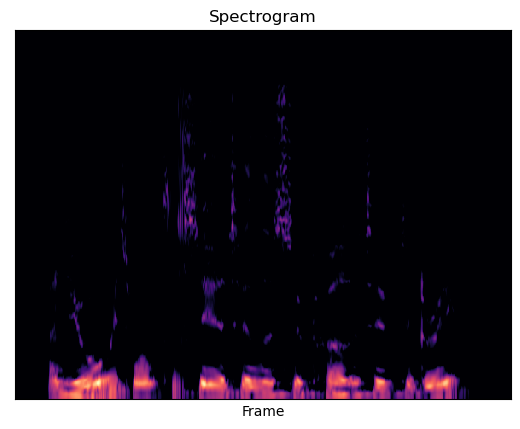

In [240]:
# La resintetizamos con World
y = world_resynthesis(x, fs, num_mfcc=25, whispered=False, frame_period=5)
Audio(y, rate=fs)

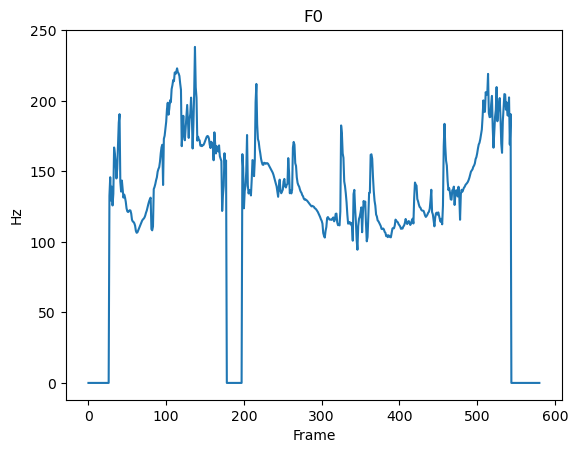

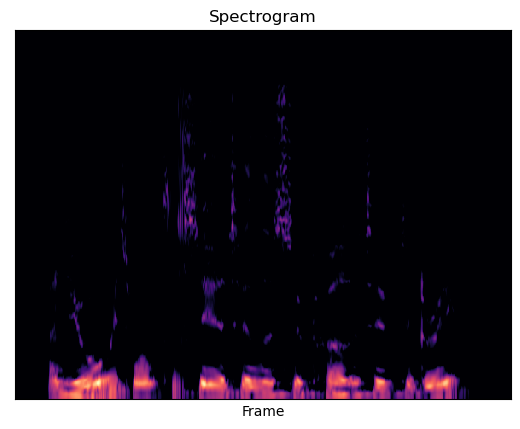

In [227]:
# Ahora la resintetizamos como voz susurrante (whispered)
y_whisp = world_resynthesis(x, fs, num_mfcc=25, whispered=True, frame_period=5)
Audio(y_whisp, rate=fs)

## Ejemplo de codificación y decodificación de una señal de voz a 8 kHz

In [235]:
# Leemos la señal
x, fs = sf.read('audio8kHz.wav')
Audio(x, rate=fs)

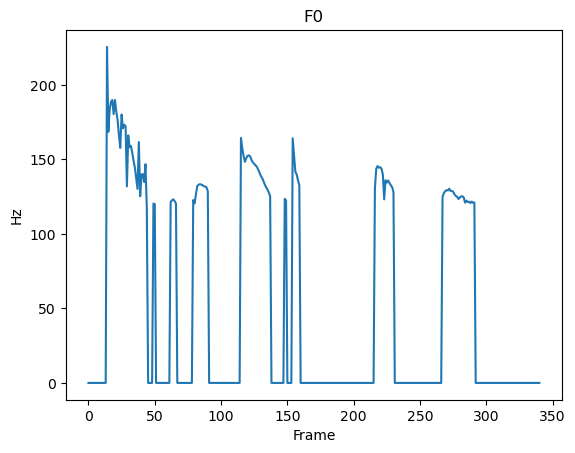

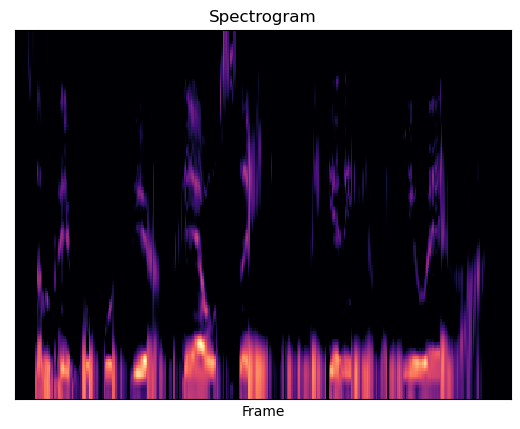

In [236]:
# La resintetizamos con World
y = world_resynthesis(x, fs, num_mfcc=10, whispered=False, frame_period=10)
Audio(y, rate=fs)

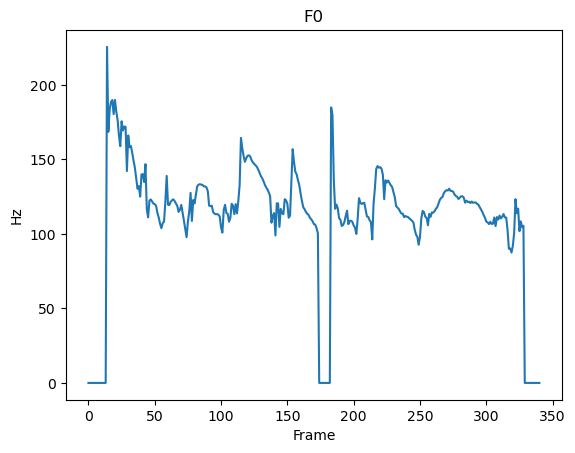

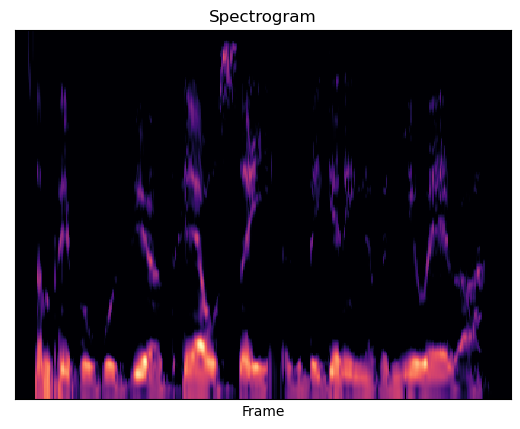

In [230]:
# Ahora resintetizamos como whispered
y_whisp = world_resynthesis(x, fs, num_mfcc=10, whispered=True, frame_period=10)
Audio(y_whisp, rate=fs)